In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint

from numpy import mean
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
#from sklearn.externals.six import StringIO  
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split

from ipynb.fs.full.preprocessing import preprocessing #import preprocessing class from preprocessing.ipynb
from ipynb.fs.full.accuracy_plots import cumulative_accuracy_plot #import fx from accuracy_plots.ipynb
from ipynb.fs.full.accuracy_plots import accuracy_by_nfeatures #import fx from accuracy_plots.ipynb

In [ ]:
#restore saved dataframes from 00_EDA.ipynb
%store -r dwt_8 wang_8 jones_8
dwt_8 = dwt_8
wang_8 = wang_8
jones_8 = jones_8

%store -r dwt_topten_8 wang_topten_8 jones_topten_8
dwt_topten_8 = dwt_topten_8
wang_topten_8 = wang_topten_8
jones_topten_8 = jones_topten_8

%store -r dwt_4 wang_4 jones_4
dwt_4 = dwt_4
wang_4 = wang_4
jones_4 = jones_4

%store -r dwt_topten_4 wang_topten_4 jones_topten_4
dwt_topten_4 = dwt_topten_4
wang_topten_4 = wang_topten_4
jones_topten_4 = jones_topten_4

In [3]:
def r_forest(df, n_iter = 1000):
    df = df

    subset_0 = df[df['state'] == 0]
    subset_1 = df[df['state'] == 1]

    subset_1 = subset_1.sample(n=91) #randomly sample cases to match number of controls
    df = pd.concat([subset_0, subset_1])

    x = df.loc[:, df.columns != 'state'] #features
    y = df.loc[:, df.columns == 'state'] #supervisor

    eval_metrics = { #empty dictionary to store classification report
        '0_precision': [],
        '0_recall': [],
        '0_f1-score': [],
        '0_support': [],

        '1_precision': [],
        '1_recall': [],
        '1_f1-score': [],
        '1_support': [],
        
        'accuracy': [],
        'accuracy_train': [],
    }
    
    for i in range(n_iter): 

        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.67)
        
        tree_model = RandomForestClassifier()
        tree_model.fit(x_train, y_train.values.ravel())
        y_pred = tree_model.predict(x_test)

        report = classification_report(y_test, y_pred, output_dict=True)

        y_pred_train = tree_model.predict(x_train)
        report_train = classification_report(y_train, y_pred_train, output_dict=True)

        eval_metrics['0_precision'].append(report['0']['precision']) #store classification_report values in dictionary
        eval_metrics['0_recall'].append(report['0']['recall'])
        eval_metrics['0_f1-score'].append(report['0']['f1-score'])
        eval_metrics['0_support'].append(report['0']['support'])

        eval_metrics['1_precision'].append(report['1']['precision'])
        eval_metrics['1_recall'].append(report['1']['recall'])
        eval_metrics['1_f1-score'].append(report['1']['f1-score'])
        eval_metrics['1_support'].append(report['1']['support'])

        eval_metrics['accuracy'].append(report['accuracy'])
        eval_metrics['accuracy_train'].append(report_train['accuracy'])

    eval_metrics_df = pd.DataFrame.from_dict(eval_metrics) #convert dictionary to dataframe

    return eval_metrics_df

In [4]:
acc_df_dwt = r_forest(dwt10, n_iter=1000)
acc_df_wang = r_forest(wang10, n_iter=1000)
acc_df_jones = r_forest(jones10, n_iter=1000)

print('DWT Method Accuracy ', round(acc_df_dwt['accuracy'].mean(), 4))
print('Wang Method Accuracy ', round(acc_df_wang['accuracy'].mean(), 4))
print('Jones Method Accuracy ', round(acc_df_jones['accuracy'].mean(), 4))

DWT Method Accuracy  0.9174
Wang Method Accuracy  0.9422
Jones Method Accuracy  0.8082


In [5]:
acc_dwt_4 = r_forest(dwt_topten_4, n_iter=1000)
acc_wang_4 = r_forest(wang_topten_4, n_iter=1000)
acc_jones_4 = r_forest(jones_topten_4, n_iter=1000)

print('DWT Method Accuracy ', round(acc_dwt_4['accuracy'].mean(), 4))
print('Wang Method Accuracy ', round(acc_wang_4['accuracy'].mean(), 4))
print('Jones Method Accuracy ', round(acc_jones_4['accuracy'].mean(), 4))

DWT Method Accuracy  0.8193
Wang Method Accuracy  0.7765
Jones Method Accuracy  0.8054


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'r_forest for Jones'}, xlabel='nth Sampling Iteration', ylabel='Accuracy'>)

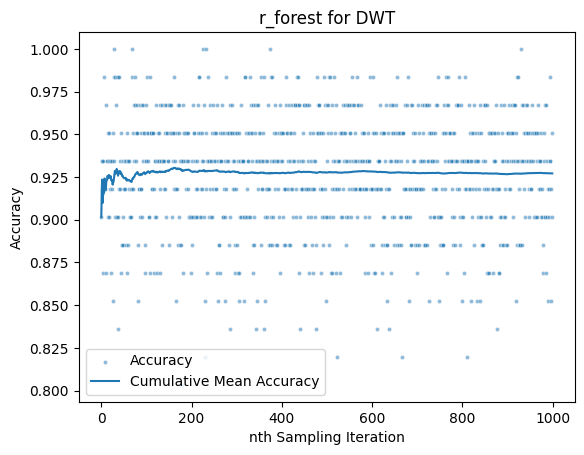

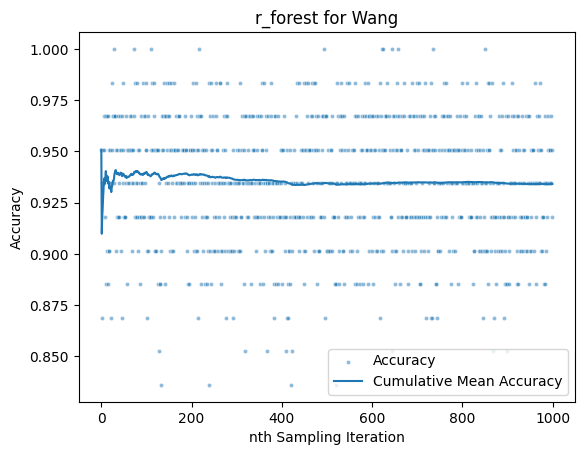

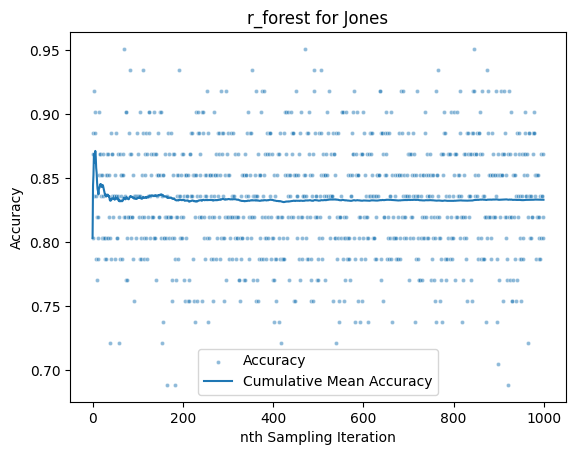

In [8]:
#calling imported function from accuracy_plots.ipynb
cumulative_accuracy_plot(classifier_name = 'r_forest',
                           df=acc_df_dwt,
                           df_name='DWT')


cumulative_accuracy_plot(classifier_name = 'r_forest',
                           df=acc_df_wang,
                           df_name='Wang')


cumulative_accuracy_plot(classifier_name = 'r_forest',
                           df=acc_df_jones,
                           df_name='Jones')

In [ ]:
r_forest_feat_accuracy_dwt = accuracy_by_nfeatures(class_instance=prep_dwt, file_name='DWT', classifier=r_forest, n_features=29, n_iter=500)
r_forest_feat_accuracy_wang = accuracy_by_nfeatures(class_instance=prep_wang, file_name='Wang', classifier=r_forest, n_features=29, n_iter=500)
r_forest_feat_accuracy_jones = accuracy_by_nfeatures(class_instance=prep_jones, file_name='Jones', classifier=r_forest, n_features=29, n_iter=500)

In [ ]:
r_forest_feat_accuracy_dwt = r_forest_feat_accuracy_dwt.rename(
                               columns = lambda col: f"{col}_dwt"
                               if col not in ('n_features', 'file_name') else col)


r_forest_feat_accuracy_wang = r_forest_feat_accuracy_wang.rename(
                               columns = lambda col: f"{col}_wang"
                               if col not in ('n_features', 'file_name') else col)


r_forest_feat_accuracy_jones = r_forest_feat_accuracy_jones.rename(
                               columns = lambda col: f"{col}_jones"
                               if col not in ('n_features', 'file_name') else col)    

In [ ]:
#merge three dataframes on n_features
merged_feat_accuracy_r_forest = r_forest_feat_accuracy_dwt.merge(r_forest_feat_accuracy_wang, how='right', on='n_features').merge(r_forest_feat_accuracy_jones, how='right', on='n_features')

merged_feat_accuracy_r_forest.plot(
           x='n_features',
           y=['mean_dwt', 'mean_train_dwt', 'mean_wang', 'mean_train_wang', 'mean_jones', 'mean_train_jones'],
           marker='.',
           title='r_forest for DWT, Wang, and Jones Methods',
           xlabel="Number of Selected Features by Fisher's Criterion",
           ylabel='Accuracy',
           figsize=(10,5))

plt.legend(['DWT Test', 'DWT Train', 'Wang Test', 'Wang Train', 'Jones Test', 'Jones Train'], loc='lower right')